# RBF Networks for Clustering


What if we don't have labels, and we just want to uncover structure in the data?

Well of course we can do that using k-means clustering, but we can also do it using a biologically-inspired method called Hebbian learning that in some ways resembles RBF networks.

## Acknowledgments

This whole lecture is courtesy of Oliver Layton.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Do Hebbian Learning 

We will do this with a no-hidden-layer network.
* The input layer has one node for each variable (feature) in the input data
* The output layer has one node, which outputs its activation based on the input data and the edge weights
* There is no bias node
* We initialize the edge weights at random
* We update the edge weights $w_i$ using Hebb's rule: $w_j(T) = w_j(T-1) + \eta x_{ij} z_i$, where $z_i$ is the activation output for data point $\vec{x_i}$ and $\eta$ is a small update factor (learning rate)
  * $x_{ij} z_i$ updates the weights based on the correlation between $x_{ij}$ and $z_i$; if they are both positive / negative, then $w_j$ increases from time $T-1$ to time $T$; else it decreases
  * Hebb's rule applied naively leads to weights that increase without bound
  * We use Oja's rule to correct: $w_j(T) = w_j(T-1) + \eta x_{ij} z_i - \eta x_{ij} {z_i}^2 = w_j(T-1) + \eta z_i(x_{ij} - {z_i})$

The goal in Hebbian learning is to learn weights based on training samples that represent key patterns in the training data.

In [2]:
def fit(data, eta=0.01, n_epochs=150):
    '''Do Hebbian learning on the data samples (using Oja's Rule) and learning rate of `eta`.

    Parameters:
    -----------
    data: ndarray. shape=(N, M)
        Data samples
    eta: float.
        Learning rate for weight update
    n_epochs: int.
        Number of epochs to train (i.e. number of passes/presentations of data the the network)

    Returns:
    -----------
    wts. ndarray. shape=(M,).
        The learned network weights
    '''
    # Number of data pts and features
    N, M = data.shape

    # Initialize weights randomly, centered at 0
    wts = 0.1*np.random.rand(M) - 0.1/2
    prev_wts = wts + 1

    # Do `n_epochs` passes through the data
    for j in range(n_epochs):
        print('weights at epoch', str(j), ':\n', wts)
        if np.array_equal(wts, prev_wts):
            return wts
        prev_wts = wts
        # Train by processing each sample
        for i in range(N):
            # Sample x_i
            xi = data[i]

            # Network output
            zi = xi @ wts

            # Update wts via Hebbian Learning
            wts = wts + eta*zi*(xi - zi*wts)
    return wts

# Predict

To predict, we would just multiply new data points by the learned weights to get the activation of this network for those new data points.

In [3]:
def predict(data, weights):
    return data @ weights

Let's do Hebbian learning on a random data set.

weights at epoch 0 :
 [ 0.04619364 -0.02078525]
weights at epoch 1 :
 [ 0.04753693 -0.02070645]
weights at epoch 2 :
 [ 0.04893277 -0.02059756]
weights at epoch 3 :
 [ 0.05038372 -0.02045632]
weights at epoch 4 :
 [ 0.05189249 -0.02028031]
weights at epoch 5 :
 [ 0.05346195 -0.02006695]
weights at epoch 6 :
 [ 0.05509512 -0.01981351]
weights at epoch 7 :
 [ 0.05679518 -0.0195171 ]
weights at epoch 8 :
 [ 0.05856548 -0.01917462]
weights at epoch 9 :
 [ 0.06040956 -0.01878281]
weights at epoch 10 :
 [ 0.06233114 -0.01833819]
weights at epoch 11 :
 [ 0.06433415 -0.01783706]
weights at epoch 12 :
 [ 0.06642273 -0.0172755 ]
weights at epoch 13 :
 [ 0.06860124 -0.01664936]
weights at epoch 14 :
 [ 0.07087429 -0.01595423]
weights at epoch 15 :
 [ 0.0732467  -0.01518542]
weights at epoch 16 :
 [ 0.07572358 -0.01433797]
weights at epoch 17 :
 [ 0.07831028 -0.01340663]
weights at epoch 18 :
 [ 0.08101247 -0.01238582]
weights at epoch 19 :
 [ 0.08383608 -0.01126964]
weights at epoch 20 :
 [ 0.086

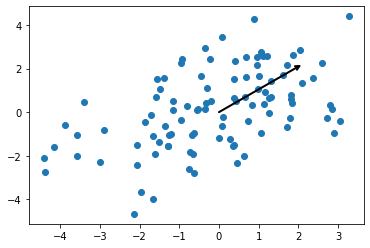

In [4]:
def run():
    # Set random seed for reproduceability
    np.random.seed(0)

    # Define data as multivariate Gaussian blob
    mu = [0, 0]
    sigma = np.array([[3, 1.5],
                      [1.5, 3]])
    data = np.random.multivariate_normal(mu, sigma, size=100)
    plt.plot(data[:, 0], data[:, 1], 'o')

    # Normalize globally to range [-0.5, 0.5]
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    data = data - 0.5

    # Train the Hebbian neural network, get the final weights
    wts = fit(data, n_epochs=150)
    print('Learned wts\n', wts)

    # Draw learned wts vector
    vectorScale = 3
    ax = plt.gca()
    ax.annotate('', vectorScale*wts, [0, 0],
                arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
    plt.show()
    return data, wts
    
data, weights = run()

# Comparison with PCA

Let's compare this weight vector with the first principal component for this data.

In [5]:
def PCA(data):
    covariance_matrix = (data.T @ data) / (len(data) - 1)
    (evals, evectors) = np.linalg.eig(covariance_matrix)
    evals_order = np.argsort(evals)[::-1]
    evals_sorted = evals[evals_order]
    evectors_sorted = evectors[:, evals_order]
    return evals_sorted, evectors_sorted

# Why do we do this?
centered_data = data - np.mean(data, axis=0)

evals, evecs = PCA(centered_data)
print(evecs[0])
print(weights)


[-0.69244223 -0.72147332]
[0.69160043 0.72227746]


# Let's use Hebbian learning on a real dataset!

## Load the Data

In [6]:
def type_converter(x):
    values = ['setosa', 'versicolor', 'virginica']
    return float(values.index(x))

def inverse_type_converter(x):
    values = ['setosa', 'versicolor', 'virginica']
    return values[x]


columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
iris = np.array(np.genfromtxt('data/iris.csv', delimiter=',', converters={4: type_converter}, skip_header=2, dtype=float, encoding='utf-8'))
print(iris.shape, iris.dtype)

(150, 5) float64


## Look at the Data

          0         1         2         3         4
0  7.900000  4.400000  6.900000  2.500000  2.000000
1  4.300000  2.000000  1.000000  0.100000  0.000000
2  5.843333  3.057333  3.758000  1.199333  1.000000
3  0.681122  0.188713  3.095503  0.577133  0.666667


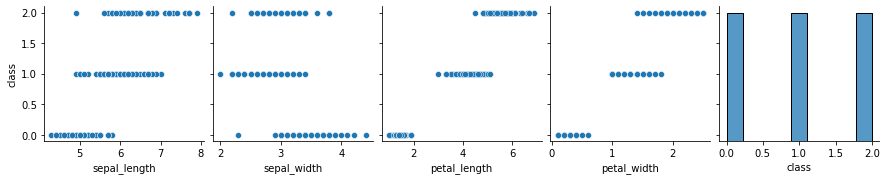

In [7]:
def get_summary_statistics(data):
    "Get the max, min, mean, var for each variable in the data."
    return pd.DataFrame(np.array([data.max(axis=0), data.min(axis=0), data.mean(axis=0), data.var(axis=0)]))

print(get_summary_statistics(iris))

df = pd.DataFrame(iris, columns=columns)
sns.pairplot(df, y_vars = ["class"], kind = "scatter")

## Split the Data 

Not for clustering!

## Clean the Data

Nothing to see here for the iris data

## Consider Dimensionality Reduction

Nothing to see here for the iris data

## Consider Transforming/Normalizing the Data

In [8]:
def homogenizeData(data):
    return np.append(data, np.array([np.ones(data.shape[0], dtype=float)]).T, axis=1)
   
def zScore(data, translateTransform=None, scaleTransform=None):
    "z score."
    homogenizedData = np.append(data, np.array([np.ones(data.shape[0], dtype=float)]).T, axis=1)
    if translateTransform is None:
        translateTransform = np.eye(homogenizedData.shape[1])
        for i in range(homogenizedData.shape[1]):
            translateTransform[i, homogenizedData.shape[1]-1] = -homogenizedData[:, i].mean()
    if scaleTransform is None:
        diagonal = [1 / homogenizedData[:, i].std() if homogenizedData[:, i].std() != 0 else 1 for i in range(homogenizedData.shape[1])]
        scaleTransform = np.eye(homogenizedData.shape[1], dtype=float) * diagonal
    data = (scaleTransform@translateTransform@homogenizedData.T).T
    return translateTransform, scaleTransform, data[:, :data.shape[1]-1]

translateTransform, scaleTransform, transformed_data = zScore(iris)

## Fit the Model

In [9]:
weights = fit(transformed_data)

weights at epoch 0 :
 [-0.02591712 -0.03997061 -0.04835704  0.04295293  0.01699165]
weights at epoch 1 :
 [ 0.37877227 -0.1283567   0.40340835  0.49001795  0.50263329]
weights at epoch 2 :
 [ 0.45911196 -0.06418399  0.47107267  0.522604    0.5427784 ]
weights at epoch 3 :
 [ 0.45942381 -0.06335247  0.47109839  0.52253609  0.54264786]
weights at epoch 4 :
 [ 0.45942682 -0.06334354  0.47109812  0.5225359   0.54264667]
weights at epoch 5 :
 [ 0.45942685 -0.06334345  0.47109812  0.5225359   0.54264666]
weights at epoch 6 :
 [ 0.45942685 -0.06334345  0.47109812  0.5225359   0.54264666]
weights at epoch 7 :
 [ 0.45942685 -0.06334345  0.47109812  0.5225359   0.54264666]
weights at epoch 8 :
 [ 0.45942685 -0.06334345  0.47109812  0.5225359   0.54264666]
weights at epoch 9 :
 [ 0.45942685 -0.06334345  0.47109812  0.5225359   0.54264666]
weights at epoch 10 :
 [ 0.45942685 -0.06334345  0.47109812  0.5225359   0.54264666]


## Comparison with PCA

In [10]:
evals, evecs = PCA(transformed_data)
print(evecs[0])
print(weights)

[-0.44486332  0.38197963  0.75062477  0.14120121  0.26983859]
[ 0.45942685 -0.06334345  0.47109812  0.5225359   0.54264666]
